# Fig 7: TCGA and Joung-MORF Analyses

- TCGA isoform abundance analysis
- Joung re-analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import gseapy as gp
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sys
import upsetplot

from adjustText import adjust_text
from Bio.Seq import Seq
from itertools import combinations
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import statsmodels.stats.multitest as smt
from upsetplot import plot

# import utils
sys.path.append("../")
sys.path.append("../data_loading")

import plotting
from plotting import (PAPER_PRESET, PAPER_FONTSIZE, 
                      nice_boxplot, mimic_r_boxplot, annotate_pval, 
                      y2h_ppi_per_tf_gene_plot)

from data_loading import (load_annotated_TFiso1_collection,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped,
                          load_ref_vs_alt_isoforms_table,
                          load_y2h_isoform_data,
                          load_ppi_partner_categories)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)
seed = 2023

## variables

In [5]:
dn_pal = {"ref": sns.color_palette("Set2")[0],
          "similar to ref.": sns.color_palette("Set2")[0],
          "rewirer": sns.color_palette("Set2")[2],
          "negative regulator": sns.color_palette("Set2")[1],
          "NA": "lightgray",
          "likely non-functional": "darkgray"}

In [6]:
# note that this is made in the other fig7 notebook in negregs_vs_rewirers dir
dn_f = "../../supp/SuppTable_NegRegs.txt"

In [7]:
hnscc_cnts_f = "../../data/processed/Nathans_analysis/HNSCC/isoCounts.TFIso-HNSCC.txt"
hnscc_tx_f = "../../data/processed/Nathans_analysis/HNSCC/transcript.TFIso-HNSCC.txt"

In [8]:
luad_cnts_f = "../../data/processed/Nathans_analysis/LUAD/isoCounts.TFIso-Lung.txt"
luad_tx_f = "../../data/processed/Nathans_analysis/LUAD/transcript.TFIso-Lung.txt"

In [9]:
brca_cnts_f = "../../data/processed/Nathans_analysis/Breast_cancer/isoCounts.BreastCancer.txt"
brca_tx_f = "../../data/processed/Nathans_analysis/Breast_cancer/transcript.BreastCancer.txt"

In [10]:
oncokb_f = "../../data/external/OncoKB_CancerGenes_Downloaded07042024.tsv"

In [11]:
deg_dir = "../../data/processed/Nathans_analysis/Joung_Reanalysis/DEGs-metacell"
joung_map_f = "../../data/internal/Joung_TF1p0_Map.txt"
tf_tgts_f = "../../data/processed/Nathans_analysis/Joung_Reanalysis/DEGs-metacell/Ensembl-TFTargets.txt"
joung_tx_preds_f = "../../data/processed/Nathans_analysis/Joung_Reanalysis/DEGs-metacell/Oncogene-TS_Alt-Ref.xlsx"

## 1. import data

In [12]:
dn = pd.read_table(dn_f)

In [13]:
hnscc = pd.read_table(hnscc_tx_f, sep="\t")
hnscc.shape

(99922, 547)

In [14]:
luad = pd.read_table(luad_tx_f, sep="\t")
luad.shape

(99922, 1147)

In [15]:
# some malformed rows in brca - none of these genes matter so skipping
skiprows=list(range(96320, 96387))+list(range(99680,99687))
brca = pd.read_table(brca_tx_f, sep="\t", skiprows=skiprows)
brca.shape

(99774, 1223)

In [16]:
oncokb = pd.read_table(oncokb_f, sep="\t")
len(oncokb)

1154

In [17]:
joung_map = pd.read_table(joung_map_f)

In [18]:
tf_tgts = pd.read_table(tf_tgts_f)

In [19]:
grns_down = pd.read_excel(joung_tx_preds_f, sheet_name="down")
grns_up = pd.read_excel(joung_tx_preds_f, sheet_name="up")

## 2. get paired samples for HNSCC + LUAD + BRCA (from same patient)

In [20]:
paired_dfs = {}

for tcga, cancer_type in zip([hnscc, luad, brca], ["HNSCC", "LUAD", "BRCA"]):
    print(cancer_type)
    
    cols = [x for x in tcga.columns if x != "UID"]
    
    # only use primary tumor samples (ignore metastases)
    cancer_samps = [x for x in cols if "-01A" in x or "-01B" in x]
    ctrl_samps = [x for x in cols if "-11A" in x or "-11B" in x]
    
    # make a dataframe to pair the samps
    cancer_samps_df = pd.DataFrame({"tcga_id": cancer_samps, "type": ["tumor"] * len(cancer_samps)})
    ctrls_samps_df = pd.DataFrame({"tcga_id": ctrl_samps, "type": ["control"] * len(ctrl_samps)})

    cancer_samps_df["patient_id"] = cancer_samps_df["tcga_id"].str.split("-", expand=True)[2]
    ctrls_samps_df["patient_id"] = ctrls_samps_df["tcga_id"].str.split("-", expand=True)[2]

    paired_df = ctrls_samps_df.merge(cancer_samps_df, on=["patient_id"], suffixes=("_ctrl", "_tumor"))
    print(len(paired_df))
    
    # de-dupe if necessary
    paired_df = paired_df.drop_duplicates(subset="patient_id")
    print(len(paired_df))
    
    paired_dfs[cancer_type] = paired_df

HNSCC
43
43
LUAD
116
105
BRCA
116
112


## 3. read in TFs + make annot map

In [21]:
tfs = load_annotated_TFiso1_collection()

reading from cache


In [22]:
data = [
    (tf, iso.name, getattr(iso, 'clone_acc', 'none'), enst_id if enst_id else 'none')
    for tf, db in tfs.items()
    for iso in db.isoforms
    for enst_id in (iso.ensembl_transcript_ids if iso.ensembl_transcript_ids else [None])
]

tf_id_map = pd.DataFrame(data, columns=["gene_name", "iso_id", "clone_acc", "enst_id"])

print(len(tf_id_map))
tf_id_map.sample(5)

1447


gene_name      iso_id         clone_acc          enst_id
921     NR2F2     NR2F2-2   NR2F2|2/2|09C09  ENST00000453270
301    ZNF131    ZNF131-2  ZNF131|2/5|02A07  ENST00000509156
435     DMTF1     DMTF1-3   DMTF1|3/5|05B01             none
463    ZNF655  ZNF655-213              none  ENST00000454654
663      MXI1      MXI1-3    MXI1|3/4|01H03  ENST00000651516

In [23]:
def merge_id(row):
    if row.enst_id == "none":
        return row.clone_acc
    else:
        return row.enst_id
    
tf_id_map["merge_id"] = tf_id_map.apply(merge_id, axis=1)

In [24]:
dd = tf_id_map[["iso_id", "gene_name"]].drop_duplicates()
print(len(dd))
gene_dict = {row.iso_id : row.gene_name for i, row in dd.iterrows()}

1197


## 4. calculate differential isoform usage (between tumor/ctrl)

In [25]:
# rename columns
def rename_col(row):
    if row.UID in list(tf_id_map["clone_acc"]):
        return row.UID
    else:
        return row.UID.split("|")[0].split(".")[0]

In [26]:
## calculate p-value using wilcoxon
def paired_pval(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    y = row[tumor_cols]
    
    # make sure x, y are filtered for nan while maintaining pair relationship
    x_filt = []
    y_filt = []
    for x_, y_ in zip(x, y):
        if pd.isnull(x_) or pd.isnull(y_):
            continue
        else:
            x_filt.append(x_)
            y_filt.append(y_)

    try:
        stat, p = wilcoxon(x_filt, y_filt)
        return p
    except:
        return np.nan
    
## return number of samps that went into p-val calc
def paired_samps(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    y = row[tumor_cols]
    
    # make sure x, y are filtered for nan while maintaining pair relationship
    x_filt = []
    y_filt = []
    for x_, y_ in zip(x, y):
        if pd.isnull(x_) or pd.isnull(y_):
            continue
        else:
            x_filt.append(x_)
            y_filt.append(y_)

    return len(x_filt)

In [27]:
res_dfs = {}
tpm_dfs = {}
gene_dfs = {}

for tcga, cancer_type in zip([hnscc, luad, brca], ["HNSCC", "LUAD", "BRCA"]):
    print(cancer_type)
    
    # rename col so we can merge
    tcga_cols = [x for x in tcga.columns if x != "UID"]
    tcga["UID"] = tcga.apply(rename_col, axis=1)
    tcga = tcga.merge(tf_id_map, left_on="UID", right_on="merge_id")
    tcga_isos = tcga.groupby("iso_id")[tcga_cols].agg("sum").reset_index()
    
    # calculate isoform ratios
    tcga_genes = pd.Series(index=tcga_isos.iso_id, data=tcga_isos.iso_id.map(gene_dict).values)

    tcga_idx = tcga_isos.set_index("iso_id", inplace=False)
    tcga_idx = tcga_idx[tcga_cols]
    tcga_gene_sum = tcga_idx.groupby(tcga_genes).transform('sum')

    f_tcga = tcga_idx/tcga_gene_sum

    # set anything w gene-level exp <= 1 to nan
    f_tcga = f_tcga * (tcga_gene_sum >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])
    
    paired_df = paired_dfs[cancer_type]
    paired_ctrls = list(paired_df["tcga_id_ctrl"])
    paired_tumors = list(paired_df["tcga_id_tumor"])
    
    tcga_isos["mean_paired-%s_tpm" % cancer_type] = tcga_isos[paired_tumors].mean(axis=1)
    tcga_isos["mean_paired-ctrls_tpm"] = tcga_isos[paired_ctrls].mean(axis=1)
    
    tcga_gene_sum["mean_paired-%s_tpm" % cancer_type] = tcga_gene_sum[paired_tumors].mean(axis=1)
    tcga_gene_sum["mean_paired-ctrls_tpm"] = tcga_gene_sum[paired_ctrls].mean(axis=1)
    
    f_tcga["mean_paired-%s_ratio" % cancer_type] = f_tcga[paired_tumors].mean(axis=1)
    f_tcga["mean_paired-ctrls_ratio"] = f_tcga[paired_ctrls].mean(axis=1)
    
    f_tcga["wilcox_pval"] = f_tcga.apply(paired_pval, ctrl_cols=paired_ctrls, tumor_cols=paired_tumors, axis=1)
    f_tcga["wilcox_n_samps"] = f_tcga.apply(paired_samps, ctrl_cols=paired_ctrls, tumor_cols=paired_tumors, axis=1)
    print(len(f_tcga))

    # filter anything out with < 20 samps
    f_tcga_filt = f_tcga[(~pd.isnull(f_tcga["wilcox_pval"])) & (f_tcga["wilcox_n_samps"] >= 20)]
    
    # filter to the same isos in tpm df
    tcga_isos_filt = tcga_isos[tcga_isos["iso_id"].isin(f_tcga_filt.index)]
    tcga_gene_sum_filt = tcga_gene_sum[tcga_gene_sum.index.isin(f_tcga_filt.index)]
    print(len(f_tcga_filt))
    print(len(tcga_isos_filt))

    f_tcga_filt["wilcox_padj"] = smt.multipletests(list(f_tcga_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]
    
    for i, row in paired_df.iterrows():
        f_tcga_filt["paired-diff_%s_ratio" % (i+1)] = f_tcga_filt[row.tcga_id_tumor]-f_tcga_filt[row.tcga_id_ctrl]
        tcga_isos_filt["paired-l2fc_%s_tpm" % (i+1)] = np.log2((tcga_isos_filt[row.tcga_id_tumor]+1)/(tcga_isos_filt[row.tcga_id_ctrl]+1))
        tcga_gene_sum_filt["paired-l2fc_%s_tpm" % (i+1)] = np.log2((tcga_gene_sum_filt[row.tcga_id_tumor]+1)/(tcga_gene_sum_filt[row.tcga_id_ctrl]+1))
    
    print(len(f_tcga_filt[f_tcga_filt["wilcox_padj"] < 0.05]))
    
    paired_cols = [x for x in f_tcga_filt.columns if x.startswith("paired")]
    f_tcga_filt["mean_paired-diff_ratio"] = f_tcga_filt[paired_cols].mean(axis=1)
    paired_cols = [x for x in tcga_isos_filt.columns if x.startswith("paired")]
    tcga_isos_filt["mean_paired-l2fc_tpm"] = tcga_isos_filt[paired_cols].mean(axis=1)
    paired_cols = [x for x in tcga_gene_sum_filt.columns if x.startswith("paired")]
    tcga_gene_sum_filt["mean_paired-l2fc_tpm"] = tcga_gene_sum_filt[paired_cols].mean(axis=1)

    res_dfs[cancer_type] = f_tcga_filt
    tpm_dfs[cancer_type] = tcga_isos_filt
    gene_dfs[cancer_type] = tcga_gene_sum_filt

HNSCC
1197
826
826
99
LUAD
1197
1000
1000
373
BRCA
1197
1043
1043
336


## 5. merge all TCGA analyses with DN categories

In [28]:
# first iso-ratio dfs
brca_iso = res_dfs["BRCA"].reset_index()
luad_iso = res_dfs["LUAD"].reset_index()
hnscc_iso = res_dfs["HNSCC"].reset_index()

brca_iso = brca_iso[["iso_id", "mean_paired-BRCA_ratio", "mean_paired-ctrls_ratio", "mean_paired-diff_ratio",
                     "wilcox_pval", "wilcox_n_samps", "wilcox_padj"]]
brca_iso.columns = ["isoform", "mean_tumor_iso_pct_brca", "mean_normal_iso_pct_brca", "mean_iso_pct_diff_brca",
                    "pval_brca", "n_samps_brca", "padj_brca"]

luad_iso = luad_iso[["iso_id", "mean_paired-LUAD_ratio", "mean_paired-ctrls_ratio", "mean_paired-diff_ratio",
                     "wilcox_pval", "wilcox_n_samps", "wilcox_padj"]]
luad_iso.columns = ["isoform", "mean_tumor_iso_pct_luad", "mean_normal_iso_pct_luad", "mean_iso_pct_diff_luad",
                    "pval_luad", "n_samps_luad", "padj_luad"]

hnscc_iso = hnscc_iso[["iso_id", "mean_paired-HNSCC_ratio", "mean_paired-ctrls_ratio", "mean_paired-diff_ratio",
                       "wilcox_pval", "wilcox_n_samps", "wilcox_padj"]]
hnscc_iso.columns = ["isoform", "mean_tumor_iso_pct_hnscc", "mean_normal_iso_pct_hnscc", 
                     "mean_iso_pct_diff_hnscc", "pval_hnscc", "n_samps_hnscc", "padj_hnscc"]

print(len(brca_iso))
print(len(luad_iso))
print(len(hnscc_iso))

1043
1000
826


In [29]:
# then tpm dfs
brca_tpm = tpm_dfs["BRCA"].reset_index()
luad_tpm = tpm_dfs["LUAD"].reset_index()
hnscc_tpm = tpm_dfs["HNSCC"].reset_index()

brca_tpm = brca_tpm[["iso_id", "mean_paired-BRCA_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
brca_tpm.columns = ["isoform", "mean_tumor_iso_tpm_brca", "mean_normal_iso_tpm_brca", "mean_iso_l2fc_brca"]

luad_tpm = luad_tpm[["iso_id", "mean_paired-LUAD_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
luad_tpm.columns = ["isoform", "mean_tumor_iso_tpm_luad", "mean_normal_iso_tpm_luad", "mean_iso_l2fc_luad"]

hnscc_tpm = hnscc_tpm[["iso_id", "mean_paired-HNSCC_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
hnscc_tpm.columns = ["isoform", "mean_tumor_iso_tpm_hnscc", "mean_normal_iso_tpm_hnscc", "mean_iso_l2fc_hnscc"]

print(len(brca_tpm))
print(len(luad_tpm))
print(len(hnscc_tpm))

1043
1000
826


In [30]:
# then gene dfs
brca_gene = gene_dfs["BRCA"].reset_index()
luad_gene = gene_dfs["LUAD"].reset_index()
hnscc_gene = gene_dfs["HNSCC"].reset_index()

brca_gene = brca_gene[["iso_id", "mean_paired-BRCA_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
brca_gene.columns = ["isoform", "mean_tumor_gene_tpm_brca", "mean_normal_gene_tpm_brca", "mean_gene_l2fc_brca"]

luad_gene = luad_gene[["iso_id", "mean_paired-LUAD_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
luad_gene.columns = ["isoform", "mean_tumor_gene_tpm_luad", "mean_normal_gene_tpm_luad", "mean_gene_l2fc_luad"]

hnscc_gene = hnscc_gene[["iso_id", "mean_paired-HNSCC_tpm", "mean_paired-ctrls_tpm", "mean_paired-l2fc_tpm"]]
hnscc_gene.columns = ["isoform", "mean_tumor_gene_tpm_hnscc", "mean_normal_gene_tpm_hnscc", "mean_gene_l2fc_hnscc"]

print(len(brca_gene))
print(len(luad_gene))
print(len(hnscc_gene))

1043
1000
826


In [31]:
pancan_iso = brca_iso.merge(luad_iso, on="isoform", how="outer").merge(hnscc_iso, on="isoform", how="outer")
print(len(pancan_iso))
pancan_tpm = brca_tpm.merge(luad_tpm, on="isoform", how="outer").merge(hnscc_tpm, on="isoform", how="outer")
print(len(pancan_tpm))
pancan_gene = brca_gene.merge(luad_gene, on="isoform", how="outer").merge(hnscc_gene, on="isoform", how="outer")
print(len(pancan_gene))
pancan_tpm = pancan_tpm.merge(pancan_gene, on="isoform", how="outer", suffixes=("_iso", "_gene"))
pancan = pancan_iso.merge(pancan_tpm, on="isoform", how="outer")
print(len(pancan))

1074
1074
1074
1074


In [32]:
pancan = pancan.merge(tf_id_map[["iso_id", "clone_acc", "gene_name"]].drop_duplicates(), 
                      left_on="isoform", right_on="iso_id").drop_duplicates()
print(len(pancan))

1074


In [33]:
# add oncogene/ts status
oncokb_mrg = oncokb[["Hugo Symbol", "Is Oncogene", "Is Tumor Suppressor Gene"]].drop_duplicates()

def cancer_status(row):
    if row["Is Oncogene"] == "Yes" and row["Is Tumor Suppressor Gene"] == "Yes":
        return "cancer-associated"
    elif row["Is Oncogene"] == "Yes":
        return "oncogene"
    elif row["Is Tumor Suppressor Gene"] == "Yes":
        return "tumor suppressor"
    else:
        return "cancer-associated"
    
oncokb_mrg["cancer_status"] = oncokb_mrg.apply(cancer_status, axis=1)
oncokb_mrg.columns = ["gene_name", "oncogene", "tumor_suppressor", "cancer_status"]
oncokb_mrg.cancer_status.value_counts()

cancer_status
cancer-associated    469
oncogene             372
tumor suppressor     313
Name: count, dtype: int64

In [34]:
pancan = pancan.merge(oncokb_mrg[["gene_name", "cancer_status"]], on="gene_name", how="left")
pancan["cancer_status"] = pancan["cancer_status"].fillna("none")
pancan.cancer_status.value_counts()

cancer_status
none                 846
cancer-associated    101
tumor suppressor      64
oncogene              63
Name: count, dtype: int64

In [35]:
def sig_status(row):
    if row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in all 3"
    elif row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05:
        return "sig. in BRCA + LUAD"
    elif row["padj_brca"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in BRCA + HNSCC"
    elif row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in LUAD + HNSCC"
    elif row["padj_brca"] < 0.05:
        return "sig. in BRCA"
    elif row["padj_luad"] < 0.05:
        return "sig. in LUAD"
    elif row["padj_hnscc"] < 0.05:
        return "sig. in HNSCC"
    else:
        return "not sig. in any"
    
def sig_status_simple(row):
    if row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_brca"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_brca"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_luad"] < 0.05:
        return "sig. in ≥1"
    elif row["padj_hnscc"] < 0.05:
        return "sig. in ≥1"
    else:
        return "not sig. in any"
    
def directionality(row):
    if row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        if row["mean_iso_pct_diff_brca"] < 0 and row["mean_iso_pct_diff_luad"] < 0 and row["mean_iso_pct_diff_hnscc"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_brca"] > 0 and row["mean_iso_pct_diff_luad"] > 0 and row["mean_iso_pct_diff_hnscc"] > 0:
            return "up in tumors"
        else:
            return "combination"
    elif row["padj_brca"] < 0.05 and row["padj_luad"] < 0.05:
        if row["mean_iso_pct_diff_brca"] < 0 and row["mean_iso_pct_diff_luad"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_brca"] > 0 and row["mean_iso_pct_diff_luad"] > 0:
            return "up in tumors"
        else:
            return "combination"
    elif row["padj_brca"] < 0.05 and row["padj_hnscc"] < 0.05:
        if row["mean_iso_pct_diff_brca"] < 0 and row["mean_iso_pct_diff_hnscc"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_brca"] > 0 and row["mean_iso_pct_diff_hnscc"] > 0:
            return "up in tumors"
        else:
            return "combination"
    elif row["padj_luad"] < 0.05 and row["padj_hnscc"] < 0.05:
        if row["mean_iso_pct_diff_luad"] < 0 and row["mean_iso_pct_diff_hnscc"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_luad"] > 0 and row["mean_iso_pct_diff_hnscc"] > 0:
            return "up in tumors"
        else:
            return "combination"
    elif row["padj_brca"] < 0.05:
        if row["mean_iso_pct_diff_brca"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_brca"] > 0:
            return "up in tumors"
    elif row["padj_luad"] < 0.05:
        if row["mean_iso_pct_diff_luad"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_luad"] > 0:
            return "up in tumors"
    elif row["padj_hnscc"] < 0.05:
        if row["mean_iso_pct_diff_hnscc"] < 0:
            return "down in tumors"
        elif row["mean_iso_pct_diff_hnscc"] > 0:
            return "up in tumors"
    else:
        return "not sig. in any"

pancan["sig_status"] = pancan.apply(sig_status, axis=1)
pancan["sig_status_simple"] = pancan.apply(sig_status_simple, axis=1)
pancan["directionality"] = pancan.apply(directionality, axis=1)
pancan.directionality.value_counts()

directionality
not sig. in any    529
up in tumors       261
down in tumors     247
combination         37
Name: count, dtype: int64

In [36]:
dn_melt = dn[["gene_symbol", "reference_isoform"]]
dn_melt.columns = ["gene_symbol", "isoform"]
dn_melt["dn_cat"] = "ref"
dn_melt2 = dn[["gene_symbol", "alternative_isoform", "alt_iso_classification"]]
dn_melt2.columns = ["gene_symbol", "isoform", "dn_cat"]
dn_melt = pd.concat([dn_melt, dn_melt2], ignore_index=True)
dn_melt.fillna("NA", inplace=True)
dn_melt.dn_cat.value_counts()

dn_cat
ref                      447
NA                       272
negative regulator       103
rewirer                   56
similar to ref.           15
likely non-functional      1
Name: count, dtype: int64

In [37]:
pancan = pancan.merge(dn_melt, on="isoform", how="left").drop_duplicates()
len(pancan)
pancan.dn_cat.value_counts()

dn_cat
NA                       238
ref                      218
negative regulator        94
rewirer                   47
similar to ref.           15
likely non-functional      1
Name: count, dtype: int64

In [38]:
pancan_lib = pancan[~pd.isnull(pancan["dn_cat"])]
print(len(pancan_lib))

613


## 6. plot significant isoforms across cancers

In [39]:
brca_sig = set(pancan[pancan['padj_brca'] < 0.05]['isoform'])
print(len(brca_sig))
luad_sig = set(pancan[pancan['padj_luad'] < 0.05]['isoform'])
print(len(luad_sig))
hnscc_sig = set(pancan[pancan['padj_hnscc'] < 0.05]['isoform'])
print(len(hnscc_sig))

336
373
99


545


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


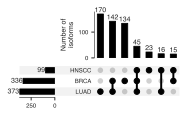

In [40]:
contents = {"BRCA": brca_sig, "LUAD": luad_sig, "HNSCC": hnscc_sig}
contents = upsetplot.from_contents(contents)

all_sig = set(brca_sig).union(set(luad_sig)).union(set(hnscc_sig))
print(len(all_sig))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=16, 
     intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("Number of\nisoforms")
d["intersections"].grid(False)
d["totals"].grid(False)
fig.savefig("../../figures/fig7/PanCan_UpSetPlot.pdf", dpi="figure", bbox_inches="tight")

In [41]:
brca_sig = set(pancan_lib[pancan_lib['padj_brca'] < 0.05]['isoform'])
print(len(brca_sig))
luad_sig = set(pancan_lib[pancan_lib['padj_luad'] < 0.05]['isoform'])
print(len(luad_sig))
hnscc_sig = set(pancan_lib[pancan_lib['padj_hnscc'] < 0.05]['isoform'])
print(len(hnscc_sig))

190
216
63


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


314


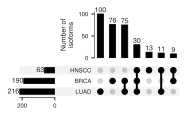

In [42]:
contents = {"BRCA": brca_sig, "LUAD": luad_sig, "HNSCC": hnscc_sig}
contents = upsetplot.from_contents(contents)

all_sig = set(brca_sig).union(set(luad_sig)).union(set(hnscc_sig))
print(len(all_sig))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=16, 
     intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("Number of\nisoforms")
d["intersections"].grid(False)
d["totals"].grid(False)
fig.savefig("../../figures/fig7/PanCan_UpSetPlot.TF1p0_Only.pdf", dpi="figure", bbox_inches="tight")

395
289


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


['SMAD4-1' 'LEF1-2' 'ELK4-2' 'PPARG-2' 'STAT3-2' 'STAT3-3' 'STAT5A-2'
 'NFE2L2-3' 'SMAD3-4' 'SMAD3-3' 'HIF1A-3' 'PAX8-3' 'E2F3-3' 'TCF7L2-8'
 'PPARG-4' 'MAX-3' 'TCF7L2-11' 'CREB1-1' 'PPARG-3' 'HIF1A-2' 'MAX-2'
 'NFE2L2-2' 'MAX-5' 'LEF1-3']


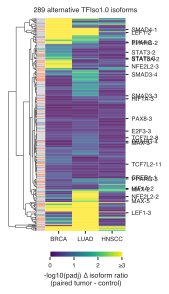

In [43]:
pc_hm = pancan_lib[pancan_lib["dn_cat"] != "ref"][["isoform", "padj_brca", "padj_luad", "padj_hnscc",
                "dn_cat"]].set_index("isoform")

print(len(pc_hm))
pc_hm = pc_hm.dropna()
print(len(pc_hm))

# lut = {"none": "lightgrey",
#        "oncogene": sns.color_palette("Set2")[1],
#        "tumor suppressor": sns.color_palette("Set2")[0],
#        "cancer-associated": sns.color_palette("Set2")[2]}
row_colors = pc_hm.dn_cat.map(dn_pal)
pc_hm.drop("dn_cat", axis=1, inplace=True)
pc_hm = -np.log10(pc_hm)

g = sns.clustermap(data=pc_hm, cmap="viridis", linewidth=0, figsize=(2, 3.5), yticklabels=False,
               xticklabels=['BRCA', 'LUAD', 'HNSCC'], vmax=3, dendrogram_ratio=(0.25, 0),
               metric='euclidean', method='complete', col_cluster=False, col_linkage=None,
               cbar_pos=(0.35, 0.02, 0.5, 0.02), cbar_kws={"label": "-log10(padj) ∆ isoform ratio\n(paired tumor - control)",
                                                    "ticks": [0, 1, 2, 3],
                                                          "orientation": "horizontal"},
                   row_colors=row_colors, colors_ratio=0.07)
_ = g.cax.set_xticklabels([0, 1, 2, "≥3"])
g.ax_row_colors.set_xticklabels('')
g.ax_row_colors.set_xticks([])
g.ax_heatmap.set_title('%s alternative TFIso1.0 isoforms' % (len(pc_hm)), fontsize=PAPER_FONTSIZE)
g.ax_heatmap.set_ylabel('')


# label specific genes
pc_hm = pancan_lib[(pancan_lib["dn_cat"] != "ref")][["isoform", "padj_brca", "padj_luad", "padj_hnscc",
                "cancer_status"]].set_index("isoform")
pc_hm["min_padj"] = pc_hm[["padj_brca", "padj_luad", "padj_hnscc"]].min(axis=1)
use_labels = list(pc_hm[(pc_hm["cancer_status"].isin(["oncogene", "tumor suppressor"])) &
                        (pc_hm["min_padj"] < 0.05)].index)
reordered_labels = pc_hm.index[g.dendrogram_row.reordered_ind].tolist()
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
g.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)

# print the labels to make more clear in illustrator
idx = np.argsort(use_ticks)
print(np.asarray(use_labels)[idx])



g.savefig("../../figures/fig7/PanCan_Heatmap.Alt_Only.pdf", dpi="figure", bbox_inches="tight")

In [44]:
nonan = pancan_lib[(~pd.isnull(pancan_lib['mean_iso_pct_diff_brca'])) &
                   (~pd.isnull(pancan_lib['mean_iso_pct_diff_luad'])) &
                   (~pd.isnull(pancan_lib['mean_iso_pct_diff_hnscc']))]

tots = pd.DataFrame(nonan[nonan["sig_status"] == "not sig. in any"].dn_cat.value_counts())
sig = pd.DataFrame(nonan[nonan["sig_status"] != "not sig. in any"].dn_cat.value_counts())

st = tots.join(sig, lsuffix="_not_sig", rsuffix="_sig")
st = st.loc[["negative regulator", "rewirer", "similar to ref.", "NA"]]
st = st/st.sum(axis=0)
st.columns = ['count_not_sig', 'count_sig']
st

count_not_sig  count_sig
dn_cat                                      
negative regulator       0.210145   0.333333
rewirer                  0.144928   0.106667
similar to ref.          0.036232   0.046667
NA                       0.608696   0.513333

In [45]:
tots

count
dn_cat                   
NA                     84
ref                    50
negative regulator     29
rewirer                20
similar to ref.         5

In [46]:
nonan[nonan["sig_status"] == "not sig. in any"].dn_cat.value_counts()

dn_cat
NA                    84
ref                   50
negative regulator    29
rewirer               20
similar to ref.        5
Name: count, dtype: int64

In [47]:
fe = np.zeros((2, 2))

alts = nonan[nonan["dn_cat"].isin(["negative regulator", "rewirer", "similar to ref.", "NA"])]

fe[0, 0] = len(alts[(alts["dn_cat"] == "negative regulator") & 
                    (alts["sig_status"] != "not sig. in any")].isoform.unique())
fe[1, 0] = len(alts[(alts["dn_cat"] != "negative regulator") & 
                    (alts["sig_status"] != "not sig. in any")].isoform.unique())
fe[0, 1] = len(alts[(alts["dn_cat"] == "negative regulator") & 
                    (alts["sig_status"] == "not sig. in any")].isoform.unique())
fe[1, 1] = len(alts[(alts["dn_cat"] != "negative regulator") & 
                    (alts["sig_status"] == "not sig. in any")].isoform.unique())
print(fisher_exact(fe))
p = fisher_exact(fe)[1]

SignificanceResult(statistic=1.8793103448275863, pvalue=0.024383368986768406)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


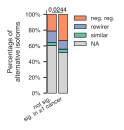

In [48]:
fig, ax = plt.subplots(figsize=(0.4, 1.5))

xs = ["not sig.", "sig. in ≥1 cancer"]
y1 = list(st[["count_not_sig", "count_sig"]].loc["NA"])
y2 = list(st[["count_not_sig", "count_sig"]].loc["similar to ref."])
b2 = np.add(y1, y2)
y3 = list(st[["count_not_sig", "count_sig"]].loc["rewirer"])
b3 = np.add(b2, y3)
y4 = list(st[["count_not_sig", "count_sig"]].loc["negative regulator"])

ax.bar(xs, y1, color=dn_pal["NA"], label="NA", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=dn_pal["similar to ref."], label="similar", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=dn_pal["rewirer"], label="rewirer", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=dn_pal["negative regulator"], label="neg. reg.", edgecolor="black", linewidth=0.5)

# annotate pval
annotate_pval(ax, 0, 1, 1.02, 0, 1.02, p, fontsize-1)

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("Percentage of\nalternative isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])
ax.set_ylim(0, 1.05)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

fig.savefig("../../figures/fig7/PanCan_DN_Stacked.pdf", dpi="figure", bbox_inches="tight")

188
151


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


['SMAD3-3' 'PPARG-4' 'E2F3-3' 'MAX-5' 'SMAD3-4' 'STAT3-2' 'STAT3-3'
 'CREB1-1']


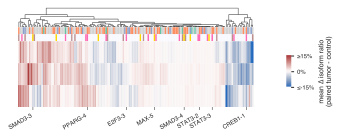

In [49]:
pc_hm = pancan_lib[(pancan_lib["dn_cat"] != "ref") &
                   (pancan_lib["sig_status_simple"] == "sig. in ≥1")][["isoform", "mean_iso_pct_diff_brca", 
                                                                       "mean_iso_pct_diff_luad", 
                                                                       "mean_iso_pct_diff_hnscc",
                                                                       "dn_cat",
                                                                       "cancer_status"]].set_index("isoform")

print(len(pc_hm))
pc_hm = pc_hm.dropna()
print(len(pc_hm))


row_colors1 = pc_hm.dn_cat.map(dn_pal)
row_colors2 = pc_hm.cancer_status.map({"oncogene": "hotpink",
                                       "tumor suppressor": "gold",
                                       "cancer-associated": "rosybrown",
                                       "none": "ghostwhite"})
to_plot = pc_hm.drop(["dn_cat", "cancer_status"], axis=1)

# flip fig so it fits in composite better
to_plot = to_plot.T

g = sns.clustermap(data=to_plot, cmap="vlag", linewidth=0, figsize=(3.5, 1.75), xticklabels=False,
                   yticklabels=False,
                   vmin=-0.15, vmax=0.15, dendrogram_ratio=(0, 0.2),
                   metric='euclidean', method='complete', row_cluster=False, row_linkage=None,
                   cbar_pos=(1.1, 0.3, 0.02, 0.25), 
                   cbar_kws={"label": "mean ∆ isoform ratio\n(paired tumor - control)",
                             "ticks": [-0.15, 0, 0.15],
                             "orientation": "vertical"},
                   col_colors=[row_colors1, row_colors2], colors_ratio=0.07)
_ = g.cax.set_yticklabels(["≤-15%", "0%", "≥15%"])
g.ax_col_colors.set_yticklabels('')
g.ax_col_colors.set_yticks([])
g.ax_col_colors.set_xticks([])
g.ax_heatmap.set_xlabel('')


# label specific genes
use_labels = list(pc_hm[(pc_hm['cancer_status'].isin(["oncogene", "tumor suppressor"])) &
                        (pc_hm['dn_cat'] == 'negative regulator')].index)
reordered_labels = pc_hm.index[g.dendrogram_col.reordered_ind].tolist()
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
g.ax_heatmap.set(xticks=use_ticks, xticklabels=use_labels)
g.ax_heatmap.set_xticklabels(use_labels, rotation=30, va='top', ha='right')
g.ax_heatmap.xaxis.set_tick_params(width=0.5)

# print the labels to make more clear in illustrator
idx = np.argsort(use_ticks)
print(np.asarray(use_labels)[idx])


g.savefig("../../figures/fig7/PanCan_Heatmap.Alt_Only_EffectSize.pdf", dpi="figure", bbox_inches="tight")

In [50]:
tots = pd.DataFrame(nonan[nonan["cancer_status"] == "none"].dn_cat.value_counts())
onc = pd.DataFrame(nonan[nonan["cancer_status"] == "oncogene"].dn_cat.value_counts())
ts = pd.DataFrame(nonan[nonan["cancer_status"] == "tumor suppressor"].dn_cat.value_counts())
other = pd.DataFrame(nonan[nonan["cancer_status"].isin(["cancer-associated"])].dn_cat.value_counts())

st = tots.join(onc, lsuffix="_none", rsuffix="_onc")
st2 = ts.join(other, lsuffix="_ts", rsuffix="_other")
st = st.join(st2)
st = st.loc[["negative regulator", "rewirer", "similar to ref.", "NA"]]
st = st/st.sum(axis=0)
st.fillna(0, inplace=True)
st

count_none  count_onc  count_ts  count_other
dn_cat                                                          
negative regulator    0.258621   0.315789  0.263158     0.444444
rewirer               0.133621   0.000000  0.105263     0.166667
similar to ref.       0.034483   0.105263  0.052632     0.055556
NA                    0.573276   0.578947  0.578947     0.333333

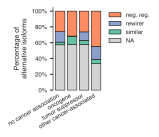

In [51]:
fig, ax = plt.subplots(figsize=(0.9, 1.5))

xs = ["no cancer association", "oncogene", "tumor suppressor", "other cancer-associated"]
y1 = list(st[["count_none", "count_onc", "count_ts", "count_other"]].loc["NA"])
y2 = list(st[["count_none", "count_onc", "count_ts", "count_other"]].loc["similar to ref."])
b2 = np.add(y1, y2)
y3 = list(st[["count_none", "count_onc", "count_ts", "count_other"]].loc["rewirer"])
b3 = np.add(b2, y3)
y4 = list(st[["count_none", "count_onc", "count_ts", "count_other"]].loc["negative regulator"])

ax.bar(xs, y1, color=dn_pal["NA"], label="NA", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=dn_pal["similar to ref."], label="similar", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=dn_pal["rewirer"], label="rewirer", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=dn_pal["negative regulator"], label="neg. reg.", edgecolor="black", linewidth=0.5)


# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("Percentage of\nalternative isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])
ax.set_ylim(0, 1.05)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

#fig.savefig("../../figures/fig7/PanCan_DN_Stacked.OncoKB.pdf", dpi="figure", bbox_inches="tight")

## 7. CREB1 vignette

In [52]:
to_plot_brca = res_dfs['BRCA'].reset_index()

paired_ctrls = list(paired_dfs['BRCA']["tcga_id_ctrl"])
paired_tumors = list(paired_dfs['BRCA']["tcga_id_tumor"])
    
brca_isos_paired = to_plot_brca[["iso_id"] + paired_ctrls + paired_tumors]
new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(paired_ctrls)]
new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(paired_tumors)]
brca_isos_paired.columns = ["iso_id"] + new_ctrl_cols + new_tumor_cols
brca_isos_paired = brca_isos_paired.merge(pancan[['iso_id', 'gene_name']], on='iso_id')

In [53]:
creb1 = pancan[pancan['gene_name'] == 'CREB1']
creb1

isoform  mean_tumor_iso_pct_brca  mean_normal_iso_pct_brca  \
45  CREB1-1                 0.740075                  0.795778   
46  CREB1-2                 0.259925                  0.204222   

    mean_iso_pct_diff_brca     pval_brca  n_samps_brca     padj_brca  \
45               -0.055703  9.895687e-10         112.0  2.563960e-08   
46                0.055703  9.895687e-10         112.0  2.563960e-08   

    mean_tumor_iso_pct_luad  mean_normal_iso_pct_luad  mean_iso_pct_diff_luad  \
45                 0.684294                  0.785956               -0.101662   
46                 0.315706                  0.214044                0.101662   

    ...  mean_gene_l2fc_hnscc   iso_id        clone_acc  gene_name  \
45  ...               0.56393  CREB1-1  CREB1|1/2|02E01      CREB1   
46  ...               0.56393  CREB1-2  CREB1|2/2|01F12      CREB1   

    cancer_status     sig_status  sig_status_simple  directionality  \
45       oncogene  sig. in all 3         sig. in ≥1  down in tumors   
46       oncogene  sig. in all 3         sig. in ≥1    up in tumors   

    gene_symbol              dn_cat  
45        CREB1  negative regulator  
46        CREB1                 ref  

[2 rows x 46 columns]

In [54]:
f_brca_paired_melt = pd.melt(brca_isos_paired, id_vars=["gene_name", "iso_id"])
f_brca_paired_melt["samp"] = f_brca_paired_melt["variable"].str.split(" ", expand=True)[0]

2.5639596600643643e-08


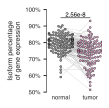

In [55]:
fig = plt.figure(figsize=(1, 1.5))

# plot alt isoform only
tmp = f_brca_paired_melt[f_brca_paired_melt["gene_name"] == "CREB1"]
alt = tmp[tmp["iso_id"] == "CREB1-1"]

ax = sns.swarmplot(data=alt, x="samp", y="value", s=2,
                   palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]},
                   alpha=0.75, linewidth=0.5, edgecolor="black",
                   order=["normal", "tumor"])

norm_paths = ax.collections[0].get_offsets()
norm_x, norm_y = norm_paths[:, 0], norm_paths[:, 1]

tumor_paths = ax.collections[1].get_offsets()
tumor_x, tumor_y = tumor_paths[:, 0], tumor_paths[:, 1]

for i in range(norm_x.shape[0]):
    x = [norm_x[i], tumor_x[i]]
    y = [norm_y[i], tumor_y[i]]
    ax.plot(x, y, linestyle="dashed", color="darkgrey", linewidth=0.25)

# annotate w p-vals
padj = creb1[creb1['iso_id'] == 'CREB1-1']['padj_brca'].iloc[0]
print(padj)
annotate_pval(ax, 0, 1, 0.95, 0, 0.95, padj, fontsize-1)

ax.set_xlabel("")
ax.set_ylim((0.5, 1.))
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels("%s%%" % x for x in [50, 60, 70, 80, 90, 100])
ax.set_ylabel("Isoform percentage\nof gene expression")
#ax.set_title("CREB1 alternative isoform\nin paired BRCA samples")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

#fig.savefig("../../figures/fig7/BRCA_CREB1_swarmplot_paired.pdf", dpi="figure", bbox_inches="tight")

In [56]:
paired_ratio_cols = [x for x in to_plot_brca.columns if x.startswith('paired-diff')]

82
30
112


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


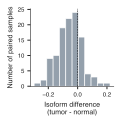

In [57]:
creb1_iso_diff = to_plot_brca[to_plot_brca["iso_id"] == "CREB1-1"][paired_ratio_cols]
creb1_iso_diff = pd.melt(creb1_iso_diff)
creb1_iso_diff = creb1_iso_diff[~pd.isnull(creb1_iso_diff["value"])]

fig = plt.figure(figsize=(1.5, 1.4))
ax = sns.histplot(data=creb1_iso_diff, x="value", color="slategrey")
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.set_xlabel("Isoform difference\n(tumor - normal)")
ax.set_ylabel("Number of paired samples")

print(len(creb1_iso_diff[creb1_iso_diff["value"] < 0]))
print(len(creb1_iso_diff[creb1_iso_diff["value"] > 0]))
print(len(creb1_iso_diff))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_CREB1_iso_diff_hist.pdf", dpi="figure", bbox_inches="tight")

In [58]:
to_plot_brca_gene = gene_dfs['BRCA'].reset_index()

brca_genes_paired = to_plot_brca_gene[["iso_id"] + paired_ctrls + paired_tumors]
brca_genes_paired.columns = ["iso_id"] + new_ctrl_cols + new_tumor_cols
brca_genes_paired = brca_genes_paired.merge(pancan[['iso_id', 'gene_name']], on='iso_id')
brca_genes_paired = brca_genes_paired[['gene_name'] + new_ctrl_cols + new_tumor_cols].drop_duplicates()

In [59]:
brca_genes_paired["wilcox_pval"] = brca_genes_paired.apply(paired_pval, ctrl_cols=new_ctrl_cols, tumor_cols=new_tumor_cols, axis=1)
brca_genes_paired["wilcox_n_samps"] = brca_genes_paired.apply(paired_samps, ctrl_cols=new_ctrl_cols, tumor_cols=new_tumor_cols, axis=1)
print(len(brca_genes_paired))

brca_genes_paired_filt = brca_genes_paired[(~pd.isnull(brca_genes_paired["wilcox_pval"])) & (brca_genes_paired["wilcox_n_samps"] >= 20)]
print(len(brca_genes_paired_filt))

brca_genes_paired_filt["wilcox_padj"] = smt.multipletests(list(brca_genes_paired_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]

212
212


In [60]:
brca_genes_paired_melt = pd.melt(brca_genes_paired_filt, id_vars=["gene_name"])
brca_genes_paired_melt["samp"] = brca_genes_paired_melt["variable"].str.split(" ", expand=True)[0]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


0.9121357975374634


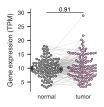

In [61]:
fig = plt.figure(figsize=(1.2, 1.5))

# plot alt isoform only
creb1 = brca_genes_paired_melt[brca_genes_paired_melt["gene_name"] == "CREB1"]

ax = sns.swarmplot(data=creb1, x="samp", y="value", s=2,
                   palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]},
                   alpha=0.75, linewidth=0.5, edgecolor="black",
                   order=["normal", "tumor"])

norm_paths = ax.collections[0].get_offsets()
norm_x, norm_y = norm_paths[:, 0], norm_paths[:, 1]

tumor_paths = ax.collections[1].get_offsets()
tumor_x, tumor_y = tumor_paths[:, 0], tumor_paths[:, 1]

for i in range(norm_x.shape[0]):
    x = [norm_x[i], tumor_x[i]]
    y = [norm_y[i], tumor_y[i]]
    ax.plot(x, y, linestyle="dashed", color="darkgrey", linewidth=0.25)

# annotate w p-vals
padj = brca_genes_paired_filt[brca_genes_paired_filt["gene_name"]== "CREB1"]["wilcox_padj"].iloc[0]
print(padj)
annotate_pval(ax, 0, 1, 30, 0, 30, padj, fontsize-1)

ax.set_xlabel("")
ax.set_ylabel("Gene expression (TPM)")
#ax.set_title("CREB1 alternative isoform\nin paired BRCA samples")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

fig.savefig("../../figures/fig7/BRCA_CREB1_gene_expression_swarmplot_paired.pdf", dpi="figure", bbox_inches="tight")

In [62]:
paired_diff_cols = [x for x in to_plot_brca_gene.columns if x.startswith('paired-l2fc')]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


59
53
112


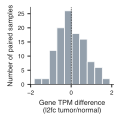

In [63]:
# using iso_id but this df is gene level
creb1_gene_diff = to_plot_brca_gene[to_plot_brca_gene["iso_id"] == "CREB1-1"][paired_diff_cols]
creb1_gene_diff = pd.melt(creb1_gene_diff)

fig = plt.figure(figsize=(1.5, 1.4))
ax = sns.histplot(data=creb1_gene_diff, x="value", color="slategrey")
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.set_xlabel("Gene TPM difference\n(l2fc tumor/normal)")
ax.set_ylabel("Number of paired samples")

print(len(creb1_gene_diff[creb1_gene_diff["value"] < 0]))
print(len(creb1_gene_diff[creb1_gene_diff["value"] > 0]))
print(len(creb1_gene_diff))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_CREB1_gene_diff_hist.pdf", dpi="figure", bbox_inches="tight")

## 8. import joung et al DEGs + target status

In [64]:
gfp_degs = {}
gfp_deg_dir = "%s/DEGs-LogFold_0.0_rawp-GFP" % deg_dir

for i, item in enumerate(os.listdir(gfp_deg_dir)):
    print(item)
    
    if item == "gene_summary.txt":
        continue
    
    df_path = os.path.join(gfp_deg_dir, item)
    df = pd.read_table(df_path)
    comp1 = item.split(".")[1].split("_")[0]
    comp2 = item.split(".")[1].split("_")[2]
    
    # focus on gfp for now
    if comp2 != "GFP":
        continue
        
    # find known tf targets
    gene_name = joung_map[joung_map["TF ORF"] == comp1]["gene_name"].iloc[0]
    tgts_sub = list(tf_tgts[tf_tgts["Symbol1"] == gene_name]["Symbol2"])
    
    if len(tgts_sub) == 0:
        df["known_target"] = False
        df["total_known_targets"] = 0
    else:
        df["known_target"] = df["Symbol"].isin(tgts_sub)
        df["total_known_targets"] = len(tgts_sub)
        
    df.columns = ["GeneID", "SystemCode", "LogFold", "rawp", "adjp", "Symbol", "avg-comp1", "avg-comp2",
                  "known_target", "total_known_targets"]
        
    gfp_degs[comp1] = df

GE.TFORF0517-PAX5_vs_GFP.txt
GE.TFORF2568-TGIF1_vs_GFP.txt
GE.TFORF2719-ZNF79_vs_GFP.txt
GE.TFORF3300-MEIS2_vs_GFP.txt
GE.TFORF2579-MEIS3_vs_GFP.txt
GE.TFORF2494-ZBTB18_vs_GFP.txt
GE.TFORF2980-FOXP3_vs_GFP.txt
GE.TFORF2580-MEIS3_vs_GFP.txt
GE.TFORF1328-TFAP2A_vs_GFP.txt
GE.TFORF2110-NR4A1_vs_GFP.txt
GE.TFORF0212-FOXP3_vs_GFP.txt
GE.TFORF3139-PPARG_vs_GFP.txt
GE.TFORF2996-TGIF1_vs_GFP.txt
GE.TFORF0495-EGR2_vs_GFP.txt
GE.TFORF3429-ZNF302_vs_GFP.txt
GE.TFORF0959-ERF_vs_GFP.txt
GE.TFORF0771-MSX2_vs_GFP.txt
GE.TFORF3313-ZBTB25_vs_GFP.txt
GE.TFORF1035-WT1_vs_GFP.txt
GE.TFORF3448-TP63_vs_GFP.txt
GE.TFORF1658-LEF1_vs_GFP.txt
GE.TFORF2815-FOSB_vs_GFP.txt
GE.TFORF0261-TCF4_vs_GFP.txt
GE.TFORF1452-DLX1_vs_GFP.txt
GE.TFORF3124-SMAD3_vs_GFP.txt
GE.TFORF1407-ZNF559_vs_GFP.txt
GE.TFORF1008-ZNF544_vs_GFP.txt
GE.TFORF2573-HSF2_vs_GFP.txt
GE.TFORF0373-NFYA_vs_GFP.txt
GE.TFORF3263-ZNF26_vs_GFP.txt
GE.TFORF0374-NFYA_vs_GFP.txt
GE.TFORF2574-HSF2_vs_GFP.txt
GE.TFORF2803-ETV2_vs_GFP.txt
GE.TFORF0820-LHX6_vs_

In [65]:
# load ref vs. alt degs
ref_degs = {}
ref_deg_dir = "%s/DEGs-LogFold_0.0_rawp-REF" % deg_dir

for i, item in enumerate(os.listdir(ref_deg_dir)):
    print(item)
    
    if item == "gene_summary.txt":
        continue
    
    df_path = os.path.join(ref_deg_dir, item)
    df = pd.read_table(df_path)
    comp1 = item.split(".")[1].split("_")[0]
    comp2 = item.split(".")[1].split("_")[2]
    
    # find known tf targets
    gene_name = joung_map[joung_map["TF ORF"] == comp1]["gene_name"].iloc[0]
    tgts_sub = list(tf_tgts[tf_tgts["Symbol1"] == gene_name]["Symbol2"])
    
    if len(tgts_sub) == 0:
        df["known_target"] = False
        df["total_known_targets"] = 0
    else:
        df["known_target"] = df["Symbol"].isin(tgts_sub)
        df["total_known_targets"] = len(tgts_sub)
        
    df.columns = ["GeneID", "SystemCode", "LogFold", "rawp", "adjp", "Symbol", "avg-comp1", "avg-comp2",
                  "known_target", "total_known_targets"]
        
    ref_degs[comp1] = df

GE.TFORF0374-NFYA_vs_TFORF0373-NFYA.txt
GE.TFORF0859-ZIC3_vs_TFORF3385-ZIC3.txt
GE.TFORF3299-MEIS2_vs_TFORF1935-MEIS2.txt
GE.TFORF0496-EGR2_vs_TFORF0495-EGR2.txt
GE.TFORF3244-ZNF483_vs_TFORF1222-ZNF483.txt
GE.TFORF0623-DDIT3_vs_TFORF3119-DDIT3.txt
GE.TFORF1957-ESR2_vs_TFORF1955-ESR2.txt
GE.TFORF0978-KLF7_vs_TFORF0979-KLF7.txt
GE.TFORF1142-HMBOX1_vs_TFORF1141-HMBOX1.txt
GE.TFORF2696-ELF5_vs_TFORF3109-ELF5.txt
GE.TFORF2973-PPARD_vs_TFORF1965-PPARD.txt
GE.TFORF1018-ZNF548_vs_TFORF1017-ZNF548.txt
GE.TFORF0959-ERF_vs_TFORF3527-ERF.txt
GE.TFORF1009-ZNF544_vs_TFORF3176-ZNF544.txt
GE.TFORF2633-TFDP2_vs_TFORF2637-TFDP2.txt
GE.TFORF3416-ZNF410_vs_TFORF2188-ZNF410.txt
GE.TFORF3178-TFDP2_vs_TFORF2637-TFDP2.txt
GE.TFORF0970-ZNF124_vs_TFORF0973-ZNF124.txt
GE.TFORF0999-ZNF302_vs_TFORF3429-ZNF302.txt
GE.TFORF3275-HMGA1_vs_TFORF3274-HMGA1.txt
GE.TFORF0314-CREM_vs_TFORF0301-CREM.txt
GE.TFORF1167-EBF3_vs_TFORF3271-EBF3.txt
GE.TFORF0825-LHX8_vs_TFORF0824-LHX8.txt
GE.TFORF3304-MITF_vs_TFORF3303-MITF.txt
GE

In [66]:
tgts_dict = {}
n_degs_df = {}

for iso in ref_degs:
    refvsalt_df = ref_degs[iso]
    refvsalt_df["neglog_adjp"] = -np.log10(refvsalt_df["adjp"])
    refvsalt_df = refvsalt_df.merge(oncokb_mrg, left_on="Symbol", right_on="gene_name",
                                    how="left")
    
    # now get the ref iso degs
    gene = joung_map[joung_map["TF ORF"] == iso]["gene_name"].iloc[0]
    ref_iso = joung_map[(joung_map["gene_name"] == gene) &
                        (joung_map["dn_cat"] == "ref")]["TF ORF"].iloc[0]
    gfp_df = gfp_degs[ref_iso]
    
    full_df = refvsalt_df.merge(gfp_df[["GeneID", "Symbol", "LogFold", "adjp"]], on=["GeneID", "Symbol"],
                                how="left", suffixes=("_vs", "_ref_vs_gfp"))
    
    altgfp_df = gfp_degs[iso]
    altgfp_df = altgfp_df[["GeneID", "Symbol", "LogFold", "adjp"]]
    altgfp_df.columns = ["GeneID", "Symbol", "LogFold_alt_vs_gfp", "adjp_alt_vs_gfp"]
    full_df = full_df.merge(altgfp_df, on=["GeneID", "Symbol"],
                            how="left")
    
    
    
    tgts_dict[iso] = full_df
    
    # uniquely up and down-regulated genes
    ref_up = set(full_df[(full_df['adjp_ref_vs_gfp'] < 0.05) & (full_df['LogFold_ref_vs_gfp'] > 0.1)]['Symbol'])
    ref_down = set(full_df[(full_df['adjp_ref_vs_gfp'] < 0.05) & (full_df['LogFold_ref_vs_gfp'] < -0.1)]['Symbol'])
    alt_up = set(full_df[(full_df['adjp_alt_vs_gfp'] < 0.05) & (full_df['LogFold_alt_vs_gfp'] > 0.1)]['Symbol'])
    alt_down = set(full_df[(full_df['adjp_alt_vs_gfp'] < 0.05) & (full_df['LogFold_alt_vs_gfp'] < -0.1)]['Symbol'])

    n_shared_up = len(ref_up.intersection(alt_up))
    n_ref_uniq_up = len(ref_up.difference(alt_up))
    n_alt_uniq_up = len(alt_up.difference(ref_up))
    
    n_shared_down = len(ref_down.intersection(alt_down))
    n_ref_uniq_down = len(ref_down.difference(alt_down))
    n_alt_uniq_down = len(alt_down.difference(ref_down))

    # summary stats
    n_degs = len(full_df[(full_df["adjp_vs"] < 0.05)])
    n_tgts = len(full_df[(full_df["known_target"] == True)])
    n_deg_tgts = len(full_df[((full_df["adjp_vs"] < 0.05) & (full_df["known_target"] == True))])
    
    n_degs_df[iso] = {"n_degs": n_degs, "n_tgts": n_tgts, "n_deg_tgts": n_deg_tgts,
                      "n_shared_up": n_shared_up, "n_ref_uniq_up": n_ref_uniq_up, "n_alt_uniq_up": n_alt_uniq_up}

In [67]:
n_degs_df = pd.DataFrame.from_dict(n_degs_df, orient="index").reset_index()
n_degs_df["pct_tgts_deg"] = (n_degs_df["n_deg_tgts"]/n_degs_df["n_tgts"])*100
n_degs_df["pct_tgts_deg"].fillna(0, inplace=True)
n_degs_df[n_degs_df["index"].str.contains("CREB1")]

index  n_degs  n_tgts  n_deg_tgts  n_shared_up  n_ref_uniq_up  \
41  TFORF3026-CREB1    8158     190          83         1203           1111   

    n_alt_uniq_up  pct_tgts_deg  
41           1575     43.684211

In [68]:
print("TOT # REF/ALT PAIRS: %s" % len(n_degs_df))
print("AVG # DEGs: %s" % (n_degs_df.n_degs.mean()))
print("MEDIAN # DEGs: %s" % (n_degs_df.n_degs.median()))
print("NUM REF/ALT PAIRS WITH ≥100 DEGs: %s" % (len(n_degs_df[n_degs_df["n_degs"] >= 100])))

TOT # REF/ALT PAIRS: 120
AVG # DEGs: 3042.366666666667
MEDIAN # DEGs: 2027.5
NUM REF/ALT PAIRS WITH ≥100 DEGs: 97


In [69]:
print("AVG # UNIQ UP REF: %s" % (n_degs_df.n_ref_uniq_up.mean()))
print("AVG # UNIQ UP ALT: %s" % (n_degs_df.n_alt_uniq_up.median()))
print("NUM REF/ALT PAIRS WITH ≥100 UNIQUE ALTs: %s" % (len(n_degs_df[n_degs_df["n_alt_uniq_up"] >= 100])))

AVG # UNIQ UP REF: 955.45
AVG # UNIQ UP ALT: 752.5
NUM REF/ALT PAIRS WITH ≥100 UNIQUE ALTs: 120


## 8. heatmap of gene set enrichments

In [70]:
gene_set = "MSigDB_Hallmark_2020"

In [71]:
gsea_res = pd.DataFrame()
res_objs = {}
for tf in ref_degs:
    print(tf)
    rnk = ref_degs[tf][["Symbol", "LogFold"]]
    rnk = rnk.sort_values(by="LogFold", ascending=False).set_index("Symbol")
    pre_res = gp.prerank(rnk=rnk,
                             gene_sets=gene_set,
                             threads=4,
                             min_size=5,
                             max_size=1000,
                             permutation_num=1000,
                             outdir=None,
                             seed=seed,
                             verbose=False)
    
    res = pre_res.res2d
    res["TF ORF"] = tf
    res_objs[tf] = pre_res
    gsea_res = pd.concat([gsea_res, res])

2025-03-04 11:36:46,681 [WARNING] Duplicated values found in preranked stats: 15.31% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0374-NFYA


2025-03-04 11:36:47,941 [WARNING] Duplicated values found in preranked stats: 21.84% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0859-ZIC3


2025-03-04 11:36:48,931 [WARNING] Duplicated values found in preranked stats: 18.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3299-MEIS2


2025-03-04 11:36:49,968 [WARNING] Duplicated values found in preranked stats: 18.86% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0496-EGR2


2025-03-04 11:36:51,012 [WARNING] Duplicated values found in preranked stats: 15.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3244-ZNF483


2025-03-04 11:36:52,282 [WARNING] Duplicated values found in preranked stats: 15.48% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0623-DDIT3


2025-03-04 11:36:53,511 [WARNING] Duplicated values found in preranked stats: 16.48% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1957-ESR2


2025-03-04 11:36:54,737 [WARNING] Duplicated values found in preranked stats: 16.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0978-KLF7


2025-03-04 11:36:55,950 [WARNING] Duplicated values found in preranked stats: 16.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1142-HMBOX1


2025-03-04 11:36:57,162 [WARNING] Duplicated values found in preranked stats: 17.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2696-ELF5


2025-03-04 11:36:58,293 [WARNING] Duplicated values found in preranked stats: 17.29% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2973-PPARD


2025-03-04 11:36:59,441 [WARNING] Duplicated values found in preranked stats: 24.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1018-ZNF548


2025-03-04 11:37:00,340 [WARNING] Duplicated values found in preranked stats: 20.26% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0959-ERF


2025-03-04 11:37:01,289 [WARNING] Duplicated values found in preranked stats: 17.39% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1009-ZNF544


2025-03-04 11:37:02,481 [WARNING] Duplicated values found in preranked stats: 17.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2633-TFDP2


2025-03-04 11:37:03,648 [WARNING] Duplicated values found in preranked stats: 20.29% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3416-ZNF410


2025-03-04 11:37:04,645 [WARNING] Duplicated values found in preranked stats: 17.91% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3178-TFDP2


2025-03-04 11:37:05,761 [WARNING] Duplicated values found in preranked stats: 16.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0970-ZNF124


2025-03-04 11:37:06,900 [WARNING] Duplicated values found in preranked stats: 21.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0999-ZNF302


2025-03-04 11:37:07,838 [WARNING] Duplicated values found in preranked stats: 15.66% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3275-HMGA1


2025-03-04 11:37:09,105 [WARNING] Duplicated values found in preranked stats: 17.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0314-CREM


2025-03-04 11:37:10,270 [WARNING] Duplicated values found in preranked stats: 18.33% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1167-EBF3


2025-03-04 11:37:11,276 [WARNING] Duplicated values found in preranked stats: 16.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0825-LHX8


2025-03-04 11:37:12,475 [WARNING] Duplicated values found in preranked stats: 17.26% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3304-MITF


2025-03-04 11:37:13,659 [WARNING] Duplicated values found in preranked stats: 15.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2065-NKX2-5


2025-03-04 11:37:14,853 [WARNING] Duplicated values found in preranked stats: 17.71% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2096-ZKSCAN1


2025-03-04 11:37:15,986 [WARNING] Duplicated values found in preranked stats: 24.78% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1343-FEZF1


2025-03-04 11:37:16,834 [WARNING] Duplicated values found in preranked stats: 20.28% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0481-HIF1A


2025-03-04 11:37:17,771 [WARNING] Duplicated values found in preranked stats: 18.60% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0827-LHX9


2025-03-04 11:37:18,790 [WARNING] Duplicated values found in preranked stats: 17.62% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2561-ZNF655


2025-03-04 11:37:19,960 [WARNING] Duplicated values found in preranked stats: 15.70% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2579-MEIS3


2025-03-04 11:37:21,172 [WARNING] Duplicated values found in preranked stats: 14.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0799-ATF3


2025-03-04 11:37:22,401 [WARNING] Duplicated values found in preranked stats: 19.43% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2166-GRHL3


2025-03-04 11:37:23,550 [WARNING] Duplicated values found in preranked stats: 17.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2168-GRHL3


2025-03-04 11:37:24,647 [WARNING] Duplicated values found in preranked stats: 15.88% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1449-DLX4


2025-03-04 11:37:25,866 [WARNING] Duplicated values found in preranked stats: 28.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2656-STAT3


2025-03-04 11:37:26,681 [WARNING] Duplicated values found in preranked stats: 17.68% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1328-TFAP2A


2025-03-04 11:37:27,847 [WARNING] Duplicated values found in preranked stats: 15.46% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0571-MEOX1


2025-03-04 11:37:29,074 [WARNING] Duplicated values found in preranked stats: 16.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3229-MAX


2025-03-04 11:37:30,281 [WARNING] Duplicated values found in preranked stats: 20.62% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3327-LHX6


2025-03-04 11:37:31,227 [WARNING] Duplicated values found in preranked stats: 17.72% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0803-ATF2


2025-03-04 11:37:32,347 [WARNING] Duplicated values found in preranked stats: 22.47% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3026-CREB1
TFORF0809-SOHLH1


2025-03-04 11:37:33,264 [WARNING] Duplicated values found in preranked stats: 16.72% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-04 11:37:34,508 [WARNING] Duplicated values found in preranked stats: 16.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1527-MXI1


2025-03-04 11:37:35,681 [WARNING] Duplicated values found in preranked stats: 22.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0209-FOXP2


2025-03-04 11:37:36,583 [WARNING] Duplicated values found in preranked stats: 17.62% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1574-ZNF174


2025-03-04 11:37:37,723 [WARNING] Duplicated values found in preranked stats: 15.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3539-ZNF747


2025-03-04 11:37:38,989 [WARNING] Duplicated values found in preranked stats: 19.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1484-TP63


2025-03-04 11:37:39,932 [WARNING] Duplicated values found in preranked stats: 18.32% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2568-TGIF1


2025-03-04 11:37:41,041 [WARNING] Duplicated values found in preranked stats: 19.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0998-ZNF302


2025-03-04 11:37:42,035 [WARNING] Duplicated values found in preranked stats: 16.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3149-ZNF254


2025-03-04 11:37:43,248 [WARNING] Duplicated values found in preranked stats: 23.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2719-ZNF79


2025-03-04 11:37:44,156 [WARNING] Duplicated values found in preranked stats: 17.15% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1008-ZNF544


2025-03-04 11:37:45,323 [WARNING] Duplicated values found in preranked stats: 16.73% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2810-ETV7


2025-03-04 11:37:46,491 [WARNING] Duplicated values found in preranked stats: 21.46% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1763-ZNF26


2025-03-04 11:37:47,393 [WARNING] Duplicated values found in preranked stats: 19.81% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2110-NR4A1


2025-03-04 11:37:48,372 [WARNING] Duplicated values found in preranked stats: 18.78% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2932-TFAP2A


2025-03-04 11:37:49,597 [WARNING] Duplicated values found in preranked stats: 18.30% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1419-VDR


2025-03-04 11:37:50,629 [WARNING] Duplicated values found in preranked stats: 18.58% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3128-IRF5


2025-03-04 11:37:51,678 [WARNING] Duplicated values found in preranked stats: 28.78% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1579-ZNF778


2025-03-04 11:37:52,480 [WARNING] Duplicated values found in preranked stats: 19.73% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1447-NR5A2


2025-03-04 11:37:53,466 [WARNING] Duplicated values found in preranked stats: 16.51% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1724-ZNF691


2025-03-04 11:37:54,642 [WARNING] Duplicated values found in preranked stats: 19.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2494-ZBTB18


2025-03-04 11:37:55,651 [WARNING] Duplicated values found in preranked stats: 16.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0903-SPDEF


2025-03-04 11:37:56,796 [WARNING] Duplicated values found in preranked stats: 17.88% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1029-RARB


2025-03-04 11:37:57,896 [WARNING] Duplicated values found in preranked stats: 18.72% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2574-HSF2


2025-03-04 11:37:58,934 [WARNING] Duplicated values found in preranked stats: 15.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1170-MLX


2025-03-04 11:38:00,118 [WARNING] Duplicated values found in preranked stats: 21.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3253-RBPJ


2025-03-04 11:38:01,078 [WARNING] Duplicated values found in preranked stats: 16.70% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1762-ZNF24


2025-03-04 11:38:02,254 [WARNING] Duplicated values found in preranked stats: 16.52% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0771-MSX2


2025-03-04 11:38:03,348 [WARNING] Duplicated values found in preranked stats: 16.52% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3464-KLF7


2025-03-04 11:38:04,539 [WARNING] Duplicated values found in preranked stats: 17.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1452-DLX1


2025-03-04 11:38:05,675 [WARNING] Duplicated values found in preranked stats: 19.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2111-NR4A1


2025-03-04 11:38:06,662 [WARNING] Duplicated values found in preranked stats: 16.28% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0115-SMAD3


2025-03-04 11:38:07,848 [WARNING] Duplicated values found in preranked stats: 20.86% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0152-THAP6


2025-03-04 11:38:08,822 [WARNING] Duplicated values found in preranked stats: 17.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0885-PPARG


2025-03-04 11:38:09,962 [WARNING] Duplicated values found in preranked stats: 17.60% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0870-NR1H3


2025-03-04 11:38:11,095 [WARNING] Duplicated values found in preranked stats: 16.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1140-HMBOX1


2025-03-04 11:38:12,273 [WARNING] Duplicated values found in preranked stats: 17.67% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0997-ZNF302


2025-03-04 11:38:13,344 [WARNING] Duplicated values found in preranked stats: 17.73% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1660-LEF1


2025-03-04 11:38:14,469 [WARNING] Duplicated values found in preranked stats: 18.45% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1811-ZNF438


2025-03-04 11:38:15,589 [WARNING] Duplicated values found in preranked stats: 15.42% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0429-PBX1


2025-03-04 11:38:16,855 [WARNING] Duplicated values found in preranked stats: 17.33% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3300-MEIS2


2025-03-04 11:38:17,958 [WARNING] Duplicated values found in preranked stats: 15.88% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2814-FOSB


2025-03-04 11:38:19,137 [WARNING] Duplicated values found in preranked stats: 18.62% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2365-ZNF398


2025-03-04 11:38:20,144 [WARNING] Duplicated values found in preranked stats: 18.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2311-RXRG


2025-03-04 11:38:21,177 [WARNING] Duplicated values found in preranked stats: 16.34% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1926-ZBTB25


2025-03-04 11:38:22,336 [WARNING] Duplicated values found in preranked stats: 15.52% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1035-WT1


2025-03-04 11:38:23,601 [WARNING] Duplicated values found in preranked stats: 16.78% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1697-E2F6


2025-03-04 11:38:24,769 [WARNING] Duplicated values found in preranked stats: 19.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1591-CTCF


2025-03-04 11:38:25,738 [WARNING] Duplicated values found in preranked stats: 15.63% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2580-MEIS3


2025-03-04 11:38:26,927 [WARNING] Duplicated values found in preranked stats: 17.66% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0452-THRA


2025-03-04 11:38:27,964 [WARNING] Duplicated values found in preranked stats: 19.91% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3053-ZBTB44


2025-03-04 11:38:28,991 [WARNING] Duplicated values found in preranked stats: 30.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2565-ZNF655


2025-03-04 11:38:29,821 [WARNING] Duplicated values found in preranked stats: 15.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0760-OVOL1


2025-03-04 11:38:31,056 [WARNING] Duplicated values found in preranked stats: 16.60% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2167-GRHL3


2025-03-04 11:38:32,208 [WARNING] Duplicated values found in preranked stats: 16.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0049-MAX


2025-03-04 11:38:33,410 [WARNING] Duplicated values found in preranked stats: 16.79% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2988-OTX2


2025-03-04 11:38:34,544 [WARNING] Duplicated values found in preranked stats: 17.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3216-ATF2


2025-03-04 11:38:35,698 [WARNING] Duplicated values found in preranked stats: 17.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0616-ZSCAN26


2025-03-04 11:38:36,754 [WARNING] Duplicated values found in preranked stats: 17.32% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2482-MXD3


2025-03-04 11:38:37,873 [WARNING] Duplicated values found in preranked stats: 16.32% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1218-PRRX1


2025-03-04 11:38:39,053 [WARNING] Duplicated values found in preranked stats: 15.64% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0212-FOXP3


2025-03-04 11:38:40,228 [WARNING] Duplicated values found in preranked stats: 19.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3138-PPARG


2025-03-04 11:38:41,214 [WARNING] Duplicated values found in preranked stats: 27.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2177-ZNF419


2025-03-04 11:38:42,161 [WARNING] Duplicated values found in preranked stats: 18.31% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1274-PKNOX1


2025-03-04 11:38:43,265 [WARNING] Duplicated values found in preranked stats: 16.66% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0521-PAX5


2025-03-04 11:38:44,550 [WARNING] Duplicated values found in preranked stats: 17.48% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1407-ZNF559


2025-03-04 11:38:45,683 [WARNING] Duplicated values found in preranked stats: 15.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2125-ZNF747


2025-03-04 11:38:46,906 [WARNING] Duplicated values found in preranked stats: 16.79% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF3137-HEY1


2025-03-04 11:38:48,020 [WARNING] Duplicated values found in preranked stats: 14.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1149-HOXA1


2025-03-04 11:38:49,252 [WARNING] Duplicated values found in preranked stats: 20.72% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1982-TBX5


2025-03-04 11:38:50,266 [WARNING] Duplicated values found in preranked stats: 20.48% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1031-RARG


2025-03-04 11:38:51,314 [WARNING] Duplicated values found in preranked stats: 15.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2393-ZNF394


2025-03-04 11:38:52,508 [WARNING] Duplicated values found in preranked stats: 22.49% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0612-RBPJ


2025-03-04 11:38:53,434 [WARNING] Duplicated values found in preranked stats: 17.66% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2564-ZNF655


2025-03-04 11:38:54,488 [WARNING] Duplicated values found in preranked stats: 17.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF2691-TEAD2


2025-03-04 11:38:55,759 [WARNING] Duplicated values found in preranked stats: 16.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1658-LEF1


2025-03-04 11:38:56,898 [WARNING] Duplicated values found in preranked stats: 16.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF0925-NR2F2


2025-03-04 11:38:58,099 [WARNING] Duplicated values found in preranked stats: 16.56% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


TFORF1454-TFEC


In [72]:
gsea_sig = gsea_res[gsea_res["FDR q-val"] < 0.25][["Term", "NES", "TF ORF", "FDR q-val"]]
print(gsea_sig.shape)
print(len(gsea_sig['Term'].unique()))

(1156, 4)
49


In [73]:
print("# OF ALTERNATIVE TFS WITH L2FCS: %s" % len(ref_degs))
print("# OF ALTERNATIVE TFS WITH A SIGNIFICANT GSEA COMPARED TO REF: %s" % len(gsea_sig["TF ORF"].unique())) 

# OF ALTERNATIVE TFS WITH L2FCS: 120
# OF ALTERNATIVE TFS WITH A SIGNIFICANT GSEA COMPARED TO REF: 117


In [74]:
# merge with joung ids
gsea_sig = gsea_sig.merge(joung_map, on="TF ORF", how="left")
print(gsea_sig.shape)

(1156, 9)


In [75]:
# merge with pancan analysis
sig_cancer = pancan[pancan['sig_status_simple'] == 'sig. in ≥1']
gsea_filt = gsea_sig[gsea_sig['tf1p0_id'].isin(sig_cancer['clone_acc'])]
print(gsea_filt.shape)
terms = list(gsea_filt["Term"].unique())
print(len(terms))
gsea_filt = gsea_filt.merge(pancan[['clone_acc', 'isoform', 'sig_status_simple', 'directionality']],
                            left_on='tf1p0_id', right_on='clone_acc')
print(gsea_filt.shape)
gsea_filt = gsea_filt.merge(oncokb_mrg[["gene_name", "cancer_status"]], on="gene_name", how="left")
print(gsea_filt.shape)

(616, 9)
49
(616, 13)
(616, 14)


In [76]:
# fix NaNs before re-indexing
gsea_filt["dn_cat"].fillna("NA", inplace=True)
gsea_filt["cancer_status"].fillna("none", inplace=True)

In [77]:
gsea_filt_pivot = pd.pivot_table(gsea_filt, values="NES", index=["isoform", "dn_cat", "cancer_status"], columns="Term")
print(gsea_filt_pivot.shape)

(64, 49)


In [78]:
dn_pal = {"ref": sns.color_palette("Set2")[0],
          "similar to ref.": sns.color_palette("Set2")[0],
          "similar": sns.color_palette("Set2")[0],
          "rewirer": sns.color_palette("Set2")[2],
          "rewire": sns.color_palette("Set2")[2],
          "negative regulator": sns.color_palette("Set2")[1],
          "DN": sns.color_palette("Set2")[1],
          "NA": "lightgray",
          "likely non-functional": "darkgray"}

In [79]:
cancer_pal = {"oncogene": "hotpink",
              "tumor suppressor": "gold",
              "cancer-associated": "rosybrown",
              "none": "ghostwhite"}

In [80]:
term_count = gsea_filt.groupby("Term")["isoform"].agg("count").reset_index()
terms_to_plot = list(term_count[term_count["isoform"] >= 1]["Term"].unique())
len(terms_to_plot)

49

In [81]:
iso_count = gsea_filt.groupby("isoform")["Term"].agg("count").reset_index()
print(len(iso_count))
print(len(iso_count[iso_count["Term"] >= 3]))

64
55


In [82]:
# create df to plot
print(gsea_filt_pivot[terms_to_plot].min().min())
to_plot = gsea_filt_pivot.reset_index()
to_plot.fillna(-10, inplace=True)

row_colors1 = to_plot.set_index("isoform").dn_cat.map(dn_pal)
row_colors2 = to_plot.set_index("isoform").cancer_status.map(cancer_pal)

to_plot.set_index("isoform", inplace=True)
to_plot = to_plot[terms]

-2.0171310526967443


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


['PPARG-4' 'PBX1-2' 'SMAD3-3' 'MAX-5' 'CREB1-1' 'HEY1-1' 'STAT3-2'
 'ZNF24-2']


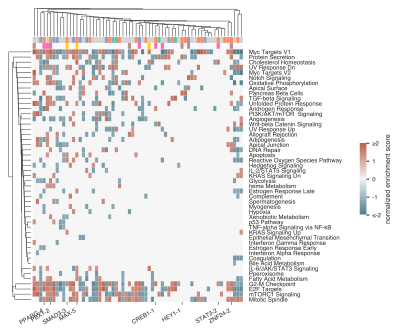

In [83]:
cmap = sns.diverging_palette(220, 20, s=60, as_cmap=True)
cmap.set_under(color='whitesmoke')

g = sns.clustermap(data=to_plot.T, cmap=cmap, linewidth=0, 
                   figsize=(5, 5), yticklabels=True,
                   xticklabels=True,
                   center=0, dendrogram_ratio=(0.1, 0.1),
                   vmin=-2, vmax=2,
                   metric='seuclidean', method='average',
                   cbar_pos=(1, 0.4, 0.02, 0.2), 
                   cbar_kws={"label": "normalized enrichment score",
                             "orientation": "vertical",
                             "ticks": [-2, -1, 0, 1, 2]},
                   col_colors=[row_colors1, row_colors2], colors_ratio=0.02,
                   row_cluster=True)

_ = g.cax.set_yticklabels(["≤-2", "-1", "0", "1", "≥2"])
g.ax_col_colors.set_yticks([])
g.ax_col_colors.set_xticks([])
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.tick_params(right=False)
g.ax_heatmap.set_xlabel("")

# label specific genes
tmp = gsea_filt_pivot.reset_index()
use_labels = list(tmp[(tmp['cancer_status'].isin(["oncogene", "tumor suppressor",
                                                              "cancer-associated"])) &
                            (tmp['dn_cat'] == 'DN')]["isoform"])
reordered_labels = to_plot.T.columns[g.dendrogram_col.reordered_ind].tolist()
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
new_names = [gsea_filt[gsea_filt['isoform'] == x]['isoform'].iloc[0] for x in use_labels]
g.ax_heatmap.set(xticks=use_ticks, xticklabels=new_names)
g.ax_heatmap.set_xticklabels(new_names, rotation=30, va='top', ha='right')
g.ax_heatmap.xaxis.set_tick_params(width=0.5)

# print the labels to make more clear in illustrator
idx = np.argsort(use_ticks)
print(np.asarray(new_names)[idx])
g.savefig("../../figures/fig7/GSEA_heatmap_full.pdf", dpi="figure", bbox_inches="tight")

In [84]:
from itertools import combinations

def jaccard_similarity(set1, set2):
    """Compute the Jaccard similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [85]:
def filter_redundant_sets(gene_sets_dict, threshold=0.8):
    """
    Remove redundant gene sets based on Jaccard similarity.

    :param gene_sets_dict: Dictionary where keys are gene set names and values are sets of genes.
    :param threshold: Threshold for Jaccard similarity above which sets are considered redundant.
    :return: Filtered dictionary of non-redundant gene sets.
    """
    gene_set_names = list(sorted(gene_sets_dict.keys(), reverse=True))
    
    # Keep track of which gene sets to remove
    to_remove = set()
    
    # Iterate through all combinations of gene sets
    for i, j in combinations(range(len(gene_set_names)), 2):
        name_i = gene_set_names[i]
        name_j = gene_set_names[j]
        if name_i not in to_remove and name_j not in to_remove:
            similarity = jaccard_similarity(gene_sets_dict[name_i], gene_sets_dict[name_j])
            if similarity >= threshold:
                # Mark one of the sets as redundant (e.g., remove gene set j)
                to_remove.add(name_j)
    
    # Return the filtered dictionary of gene sets
    filtered_gene_sets_dict = {name: genes for name, genes in gene_sets_dict.items() if name not in to_remove}
    
    return filtered_gene_sets_dict

In [86]:
# grab genes in each term
gene_set_dict = {}
for term in terms:
    genes = gp.get_library(name=gene_set, organism="Human")[term]
    gene_set_dict[term] = set(genes)

In [87]:
print(len(gene_set_dict))

filtered_gene_set_dict = filter_redundant_sets(gene_set_dict, threshold=0.05)
len(filtered_gene_set_dict)

49


28

In [88]:
# create df to plot
print(gsea_filt_pivot[filtered_gene_set_dict.keys()].min().min())
to_plot = gsea_filt_pivot.reset_index()
to_plot.fillna(-10, inplace=True)

# filter to isoforms with at least 1 sig gsea
to_include = list(to_plot[to_plot[filtered_gene_set_dict.keys()].max(axis=1) > -10]["isoform"])
to_plot = to_plot[to_plot["isoform"].isin(to_include)]

row_colors1 = to_plot.set_index("isoform").dn_cat.map(dn_pal)
row_colors2 = to_plot.set_index("isoform").cancer_status.map(cancer_pal)

to_plot.set_index("isoform", inplace=True)
to_plot = to_plot[filtered_gene_set_dict.keys()]
print(to_plot.shape)

-2.0171310526967443
(61, 28)


['SMAD3-3' 'PBX1-2' 'PPARG-4' 'MAX-5' 'ZNF24-2' 'CREB1-1' 'HEY1-1']


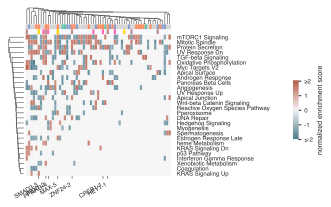

In [89]:
cmap = sns.diverging_palette(220, 20, s=60, as_cmap=True)
cmap.set_under(color='whitesmoke')

g = sns.clustermap(data=to_plot.T, cmap=cmap, linewidth=0, 
                   figsize=(4, 3.25), yticklabels=True,
                   xticklabels=True,
                   center=0, dendrogram_ratio=(0.1, 0.1),
                   vmin=-2, vmax=2,
                   metric='seuclidean', method='average',
                   cbar_pos=(1.02, 0.4, 0.02, 0.25), 
                   cbar_kws={"label": "normalized enrichment score",
                             "orientation": "vertical",
                             "ticks": [-2, -1, 0, 1, 2]},
                   col_colors=[row_colors1, row_colors2], colors_ratio=0.03,
                   row_cluster=True)

_ = g.cax.set_yticklabels(["≤-2", "-1", "0", "1", "≥2"])
g.ax_col_colors.set_yticks([])
g.ax_col_colors.set_xticks([])
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.tick_params(right=False)
g.ax_heatmap.set_xlabel("")

# label specific genes
tmp = gsea_filt_pivot.reset_index()
use_labels = list(tmp[(tmp['cancer_status'].isin(["oncogene", "tumor suppressor",
                                                              "cancer-associated"])) &
                            (tmp['dn_cat'] == 'DN')]["isoform"])
use_labels = [x for x in use_labels if x in to_include]

reordered_labels = to_plot.T.columns[g.dendrogram_col.reordered_ind].tolist()
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
new_names = [gsea_filt[gsea_filt['isoform'] == x]['isoform'].iloc[0] for x in use_labels]
g.ax_heatmap.set(xticks=use_ticks, xticklabels=new_names)
g.ax_heatmap.set_xticklabels(new_names, rotation=30, va='top', ha='right')
g.ax_heatmap.xaxis.set_tick_params(width=0.5)

# print the labels to make more clear in illustrator
idx = np.argsort(use_ticks)
print(np.asarray(new_names)[idx])
g.savefig("../../figures/fig7/GSEA_heatmap_small.pdf", dpi="figure", bbox_inches="tight")

                               Term       NES NOM p-val FDR q-val
2                    Myc Targets V1  1.484195  0.002821   0.12976
9                   Apical Junction -1.336004  0.006024  0.177401
1   Reactive Oxygen Species Pathway  1.490889   0.02623  0.183071
10                Protein Secretion  1.335759  0.047619  0.185929
8                    UV Response Dn  1.339015  0.037092  0.200538
20            Xenobiotic Metabolism -1.188043  0.063158  0.201803
6                         Apoptosis  1.361862  0.026393   0.20689
5         Unfolded Protein Response  1.380686  0.032357  0.207117
7                 KRAS Signaling Up  1.344186  0.017884  0.215908
4                   G2-M Checkpoint  1.384128  0.010072  0.240102


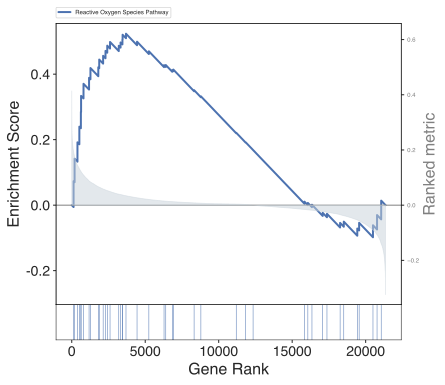

In [90]:
smad3_res = res_objs["TFORF0115-SMAD3"]
print(smad3_res.res2d[['Term', 'NES', 'NOM p-val', 'FDR q-val']].sort_values(by='FDR q-val').head(10))

ax = smad3_res.plot(terms=["Reactive Oxygen Species Pathway"])
#plt.savefig("GSEA_SMAD3_ROS.pdf", dpi="figure", bbox_inches="tight")

                          Term       NES NOM p-val FDR q-val
0              G2-M Checkpoint  1.597666       0.0  0.103165
3            Androgen Response  1.436077  0.026104  0.223849
4   Wnt-beta Catenin Signaling -1.407419  0.053785  0.233806
1               Apical Surface -1.519778  0.027574    0.2478
2            Protein Secretion   -1.4451  0.023033    0.2478
5             mTORC1 Signaling  1.361075  0.014228   0.28484
6                  E2F Targets -1.317998  0.018349  0.381684
9               Myc Targets V1  1.261327  0.035941  0.383268
7     PI3K/AKT/mTOR  Signaling -1.285379  0.081028  0.386855
11     Cholesterol Homeostasis  1.230508  0.122407  0.401144


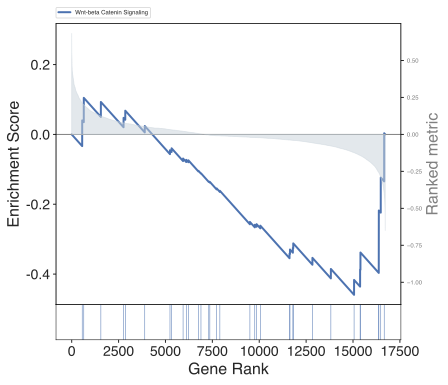

In [91]:
creb1_res = res_objs["TFORF3026-CREB1"]
print(creb1_res.res2d[['Term', 'NES', 'NOM p-val', 'FDR q-val']].sort_values(by='FDR q-val').head(10))

ax = creb1_res.plot(terms=["Wnt-beta Catenin Signaling"])
#plt.savefig("GSEA_CREB1_Wnt.pdf", dpi="figure", bbox_inches="tight")

In [92]:
sig_cancer_alt_tf1p0 = sig_cancer[(sig_cancer["dn_cat"] != "ref") &
                                  (sig_cancer["clone_acc"] != "none")]

joung_tf1p0 = joung_map[~pd.isnull(joung_map["TF ORF"])]
overlap_joung = joung_tf1p0[joung_tf1p0["tf1p0_id"].isin(sig_cancer_alt_tf1p0["clone_acc"])]

called_degs = overlap_joung[overlap_joung["TF ORF"].isin(ref_degs.keys())]

sig_gsea = called_degs[called_degs["tf1p0_id"].isin(gsea_sig["tf1p0_id"])]

print("# sig cancer alt TF1.0 isos: %s" % len(sig_cancer_alt_tf1p0["iso_id"].unique()))
print("# overlap joung: %s" % len(overlap_joung["tf1p0_id"].unique()))
print("# called DEGs: %s" % len(called_degs["tf1p0_id"].unique()))
print("# sig GSEA: %s" % len(sig_gsea["tf1p0_id"].unique()))

# sig cancer alt TF1.0 isos: 188
# overlap joung: 90
# called DEGs: 66
# sig GSEA: 64


## 9. write supplemental files

In [93]:
# supp table: paired samples used in TCGA analysis
supp_brcasamps = paired_dfs["BRCA"][["tcga_id_ctrl", "tcga_id_tumor"]]
supp_brcasamps["cancer_type"] = "BRCA"
supp_luadsamps = paired_dfs["LUAD"][["tcga_id_ctrl", "tcga_id_tumor"]]
supp_luadsamps["cancer_type"] = "LUAD"
supp_hnsccsamps = paired_dfs["HNSCC"][["tcga_id_ctrl", "tcga_id_tumor"]]
supp_hnsccsamps["cancer_type"] = "HNSCC"
supp_tcgasamps = pd.concat([supp_brcasamps, supp_luadsamps, supp_hnsccsamps])
supp_tcgasamps.cancer_type.value_counts()

cancer_type
BRCA     112
LUAD     105
HNSCC     43
Name: count, dtype: int64

In [94]:
supp_tcgasamps.to_csv("../../supp/SuppTable_TCGASamps.txt", sep="\t", index=False)

In [95]:
# supp table: TCGA results for cloned isoforms
supp_tcgares = pancan_lib[["isoform", 'mean_tumor_iso_pct_brca', 'mean_normal_iso_pct_brca',
       'mean_iso_pct_diff_brca', 'pval_brca', 'n_samps_brca', 'padj_brca',
       'mean_tumor_iso_pct_luad', 'mean_normal_iso_pct_luad',
       'mean_iso_pct_diff_luad', 'pval_luad', 'n_samps_luad', 'padj_luad',
       'mean_tumor_iso_pct_hnscc', 'mean_normal_iso_pct_hnscc',
       'mean_iso_pct_diff_hnscc', 'pval_hnscc', 'n_samps_hnscc', 'padj_hnscc']]
len(supp_tcgares)

613

In [96]:
supp_tcgares.to_csv("../../supp/SuppTable_TCGAResults.txt", sep="\t", index=False)

In [97]:
supp_joung = gsea_sig.copy()
print(len(supp_joung))

# merge with reference ID
joung_refs = joung_map[joung_map["dn_cat"] == "ref"]

supp_joung = supp_joung.merge(joung_refs, on="gene_name", suffixes=("_alt", "_ref"))
supp_joung = supp_joung[["TF ORF_alt", "tf1p0_id_alt", "TF ORF_ref", "tf1p0_id_ref", "Term", "NES", "FDR q-val"]]
supp_joung.columns = ["jound_id_alt", "alt_iso", "joung_id_ref", "ref_iso",
                      "msigdb_term", "gsea_nes", "gsea_qval"]

def format_id(row, col):
    return row[col].split("|")[0] + '-' + row[col].split("|")[1].split("/")[0]

supp_joung['alt_iso'] = supp_joung.apply(format_id, col='alt_iso', axis=1)
supp_joung['ref_iso'] = supp_joung.apply(format_id, col='ref_iso', axis=1)
print(len(supp_joung.alt_iso.unique()))
supp_joung.sample(5)

1156
117


jound_id_alt   alt_iso      joung_id_ref   ref_iso  \
1073   TFORF1149-HOXA1   HOXA1-2   TFORF3103-HOXA1   HOXA1-1   
414     TFORF1449-DLX4    DLX4-2    TFORF3021-DLX4    DLX4-1   
540   TFORF1574-ZNF174  ZNF174-3  TFORF1575-ZNF174  ZNF174-1   
1060  TFORF1407-ZNF559  ZNF559-3  TFORF3425-ZNF559  ZNF559-1   
613      TFORF1419-VDR     VDR-1     TFORF3529-VDR     VDR-2   

                          msigdb_term  gsea_nes gsea_qval  
1073                   Myc Targets V1  1.505178  0.155993  
414               Allograft Rejection  -1.58548  0.045791  
540                      Angiogenesis  1.649478  0.030797  
1060  Reactive Oxygen Species Pathway -1.594894  0.021223  
613                    Myc Targets V1   1.47381  0.240892

In [98]:
supp_joung.to_csv("../../supp/SuppTable_JoungResults.txt", sep="\t", index=False)

In [99]:
supp_joung[supp_joung["alt_iso"].str.contains("PBX1")]

jound_id_alt alt_iso    joung_id_ref ref_iso  \
848  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
849  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
850  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
851  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
852  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
853  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
854  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
855  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
856  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
857  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
858  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
859  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
860  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
861  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
862  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
863  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
864  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   
865  TFORF0429-PBX1  PBX1-2  TFORF0427-PBX1  PBX1-1   

                   msigdb_term  gsea_nes gsea_qval  
848             Myc Targets V1  1.839275   0.00235  
849  Oxidative Phosphorylation  1.578335  0.048179  
850            G2-M Checkpoint  -1.48406  0.184716  
851               Angiogenesis -1.483055  0.092767  
852                 Glycolysis  1.451472  0.128868  
853          Protein Secretion  1.445873   0.10282  
854            Mitotic Spindle -1.435495  0.101349  
855           mTORC1 Signaling  1.419349  0.109518  
856                E2F Targets  1.376278   0.13396  
857      Xenobiotic Metabolism  1.366253  0.126574  
858         TGF-beta Signaling  1.350633  0.127203  
859      Fatty Acid Metabolism  1.338085  0.127301  
860  Unfolded Protein Response  1.326083  0.126087  
861            Notch Signaling -1.320926  0.217613  
862             UV Response Dn -1.311991  0.188803  
863            heme Metabolism  1.287812   0.16088  
864             UV Response Up -1.273073  0.222585  
865                 DNA Repair  1.241035  0.217489

# create TCGA plots for website
takes a while so comment out when done

In [100]:
def paired_swarmplot(df, iso_id, cancer, padj, l2fc, fig_filename):
    fig = plt.figure(figsize=(1.5, 1.5))

    sub_melt = df[(df["iso_id"] == iso_id)]
    
    # only include vals which are not NA in both tumor and normal
    norm_nonan = list(sub_melt[(sub_melt['samp'] == 'normal') &
                          ~(pd.isnull(sub_melt['value']))]['patient'])
    tumor_nonan = list(sub_melt[(sub_melt['samp'] == 'tumor') &
                          ~(pd.isnull(sub_melt['value']))]['patient'])
    norm_tumor_nonan = list(set(norm_nonan).intersection(set(tumor_nonan)))
    sub_melt = sub_melt[sub_melt['patient'].isin(norm_tumor_nonan)]
    
    sub_melt = sub_melt.sort_values(by=['samp', 'patient'])
    if len(sub_melt) == 0:
        return None

    ax = sns.swarmplot(data=sub_melt, x="samp", y="value", s=2,
                       palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]},
                       alpha=0.75, linewidth=0.5, edgecolor="black",
                       order=["normal", "tumor"])


    norm_paths = ax.collections[0].get_offsets()
    norm_x, norm_y = norm_paths[:, 0], norm_paths[:, 1]

    tumor_paths = ax.collections[1].get_offsets()
    tumor_x, tumor_y = tumor_paths[:, 0], tumor_paths[:, 1]

    for i in range(norm_x.shape[0]):
        x = [norm_x[i], tumor_x[i]]
        y = [norm_y[i], tumor_y[i]]
        ax.plot(x, y, linestyle="dashed", color="darkgrey", linewidth=0.25)

    # add padj + l2fc to title
    ax.set_title("%s in paired %s samples\npadj: %s | mean l2fc: %s" % (iso_id, cancer, padj, l2fc))
    

    ax.set_xlabel("")
    
    # set the ylimits based on the max/min value
    max_val = sub_melt['value'].max()
    yceil = math.ceil(max_val * 10) / 10
    
    min_val = sub_melt['value'].min()
    yfloor = math.floor(min_val * 10)/10
    if yfloor == 0:
        yfloor = -0.01

    ax.set_ylim((yfloor, yceil))
    
    if yfloor == -0.01:
        yticks = np.linspace(0, yceil, 5)
    else:
        yticks = np.linspace(yfloor, yceil, 5)
        
    ax.set_yticks(yticks)
    ax.set_yticklabels(["%s%%" % int(x*100) for x in yticks])
    ax.set_ylabel("Isoform percentage\nof gene expression")

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(fig_filename, dpi="figure", bbox_inches="tight")
    plt.close()
    return fig

In [101]:
def format_number(num):
    if abs(num) < 0.001 and num != 0:
        return f"{num:.1e}"  # Format in scientific notation
    else:
        return f"{num:.3f}"  # Otherwise, return as a float with 2 decimal places

In [102]:
# for cancer in ['BRCA', 'LUAD', 'HNSCC']:
#     print(cancer)
#     tcga = res_dfs[cancer].reset_index()
#     tcga["gene_name"] = tcga.iso_id.map(gene_dict)
    
#     paired_df = paired_dfs[cancer]
#     paired_ctrls = list(paired_df["tcga_id_ctrl"])
#     paired_tumors = list(paired_df["tcga_id_tumor"])
    
#     tcga = tcga[["gene_name", "iso_id"] + paired_ctrls + paired_tumors]
#     new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(paired_ctrls)]
#     new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(paired_tumors)]
#     tcga.columns = ["gene_name", "iso_id"] + new_ctrl_cols + new_tumor_cols
    
#     tcga_melt = pd.melt(tcga, id_vars=["gene_name", "iso_id"])
#     tcga_melt["samp"] = tcga_melt["variable"].str.split(" ", expand=True)[0]
#     tcga_melt["patient"] = tcga_melt["variable"].str.split(" - ", expand=True)[1].astype(int)
    
#     # now plot per iso
#     for i, row in pancan_lib.iterrows():
#         print('  %s' % row.iso_id)
#         iso_id = row.iso_id
#         gene_name = row.gene_name
#         padj = format_number(row['padj_%s' % cancer.lower()])
#         l2fc = format_number(row["mean_iso_pct_diff_%s" % cancer.lower()])
#         fig_dir = "../../figures/for_website/tcga/%s" % gene_name
        
#         !mkdir -p $fig_dir
        
#         fig_filename = "%s/%s.%s.pdf" % (fig_dir, iso_id, cancer)
#         _ = paired_swarmplot(tcga_melt, iso_id, cancer, padj, l2fc, fig_filename)